# Library

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing import text, sequence

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense

from keras.layers import Dense, Embedding, Input, SimpleRNN, LSTM, Bidirectional
from keras.layers import Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


# Data

## Train

In [2]:
df_train = pd.read_csv("../data/input/train.csv")
targets = [
    "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"
]
X_train = df_train.comment_text
y_train = df_train[targets]

## Test

In [3]:
df_test = pd.read_csv("../data/input/test.csv")
df_test.loc[df_test.comment_text.isnull(), "comment_text"] = ""
X_test = df_test.comment_text

# Global parameters

In [4]:
batch_size = 32
epochs = 3
max_features = 20000
maxlen = 100

# Preprocessing : Tokens

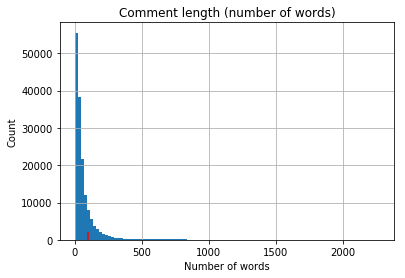

In [5]:
X_train.map(lambda x : len(x.split(" "))).hist(bins=100)
plt.vlines(100, ymin=0, ymax=2000, colors="red")
plt.title("Comment length (number of words)")
plt.xlabel("Number of words")
plt.ylabel("Count")
plt.show()

In [6]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))

list_tokenized_train = tokenizer.texts_to_sequences(X_train)
list_tokenized_test = tokenizer.texts_to_sequences(X_test)

X_train = sequence.pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = sequence.pad_sequences(list_tokenized_test, maxlen=maxlen)

# Pre-trained embedding

In [7]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')


def get_embedding_matrix(tokenizer, path_glove, embed_size,
                         max_features=20000):
    embeddings_index = dict(
        get_coefs(*o.strip().split()) for o in open(path_glove))
    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()

    word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words,
                                                            embed_size))
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [10]:
glove_path = "../data/glove/glove.6B.50d.txt"
embedding_matrix = get_embedding_matrix(
    tokenizer=tokenizer, path_glove=glove_path, embed_size=50, max_features=max_features)

# LSTM, Pooling and regularization 

In [11]:
# Define model
model = Sequential()
model.add(
    Embedding(
        max_features, embedding_matrix.shape[1], weights=[embedding_matrix]))
model.add(
    Bidirectional(
        LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation="relu"))
model.add(Dense(6, activation='sigmoid'))

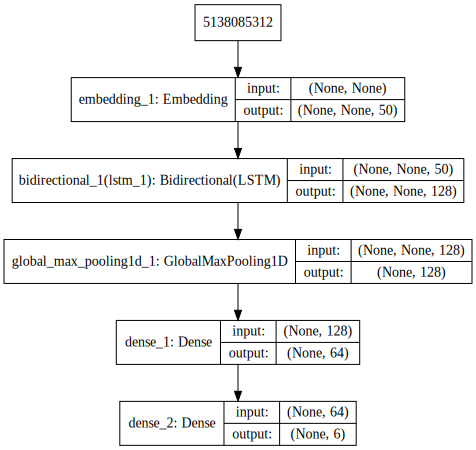

In [12]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [13]:
# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Show model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 50)          1000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         58880     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 1,067,526
Trainable params: 1,067,526
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit model
history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/3
159571/159571 [==============================] - 1259s 8ms/step - loss: 0.0569 - acc: 0.9800
Epoch 2/3
159571/159571 [==============================] - 1015s 6ms/step - loss: 0.0436 - acc: 0.9834
Epoch 3/3
159571/159571 [==============================] - 1023s 6ms/step - loss: 0.0396 - acc: 0.9846


In [16]:
model.save_weights('../data/work/complete_lstm_submission.h5')

# Predict for submission

In [17]:
predict = model.predict_proba(X_test, verbose=1)

153164/153164 [==============================] - 201s 1ms/step


# Submission

In [19]:
pd.DataFrame(
    predict, columns=targets,
    index=df_test.id).reset_index().rename(columns={
        "index": "id"
    }).to_csv(
        "../data/submissions/complete_lstm_submission.csv", index=False)